## Health and Life Style Data Analysis

# Import necessary libraries(run)

In [274]:
import xgboost
import sklearn
print("xgboost version:", xgboost.__version__)
print("scikit-learn version:", sklearn.__version__)


xgboost version: 2.1.4
scikit-learn version: 1.5.1


In [ ]:
# Imports

# Core libraries
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Stats and modeling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, LassoCV, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV

# XGBoost
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error, r2_score, classification_report, accuracy_score

#Set up data (run)


## Load Data

In [276]:
# Load data from CSV
raw_data = pd.read_csv('data.csv')

# Columns that should be numeric
numeric_columns = ['Caffeine Consumption', 'Vitamins?', 'Creatine?', 'Alcohol?', 'Bread?', 'Hours of Sleep', 'Healthy Eats']
for col in numeric_columns:
    if col in raw_data.columns:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

# Keep a copy and also save to CSV for downstream cells
data = raw_data.copy()
data.to_csv('data.csv', index=False)
print('Data saved locally to data.csv')

data

Data saved locally to data.csv


,Unnamed: 0.1,Unnamed: 0,Timestamp,Date,Caffeine Consumption,Vitamins?,Creatine?,Alcohol?,Bread?,Gym Motivation,Mood of the Day,Hours of Sleep,Healthy Eats,Location
0,0,0,NaN,3/1/2024,1,1,1,1,1,:(,:),8,7,Atlanta
1,1,1,NaN,3/2/2024,1,1,1,1,0,:(,:),9,6,Atlanta
2,2,2,NaN,3/3/2024,1,1,1,0,1,:),:),8,8,Atlanta
3,3,3,NaN,3/4/2024,1,1,1,0,0,:),:),9,7,Atlanta
4,4,4,NaN,3/5/2024,1,1,1,0,0,:),:),9,9,Atlanta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,687,687,1/23/2026 10:44:28,1/20/2026,1,1,1,0,0,:/,:),9,8,Other
688,688,688,1/23/2026 10:45:44,1/21/2026,1,1,1,0,0,:/,:/,8,7,Other
689,689,689,1/23/2026 10:46:28,1/22/2026,1,1,1,0,0,No Gym,:(,7,6,Other
690,690,690,1/25/2026 10:23:53,1/23/2026,1,1,1,0,1,:),:),10,8,Atlanta


In [277]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Timestamp,Date,Caffeine Consumption,Vitamins?,Creatine?,Alcohol?,Bread?,Gym Motivation,Mood of the Day,Hours of Sleep,Healthy Eats,Location
0,0,0,NaN,3/1/2024,1,1,1,1,1,:(,:),8,7,Atlanta
1,1,1,NaN,3/2/2024,1,1,1,1,0,:(,:),9,6,Atlanta
2,2,2,NaN,3/3/2024,1,1,1,0,1,:),:),8,8,Atlanta
3,3,3,NaN,3/4/2024,1,1,1,0,0,:),:),9,7,Atlanta
4,4,4,NaN,3/5/2024,1,1,1,0,0,:),:),9,9,Atlanta


# Preprocess Data

In [278]:
def preprocess_data_for_modeling(raw_data, numeric_columns=None, columns_to_drop=None):

    # Create a copy of the data frame
    data = raw_data.copy()

    # Drop unnecessary columns
    if columns_to_drop:
        data.drop(columns_to_drop, axis=1, inplace=True)

    # Convert specified columns to numeric, if provided
    if numeric_columns:
        for col in numeric_columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

    # Ensure the Date column is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Sort the DataFrame by date
    data = data.sort_values(by='Date').reset_index(drop=True)

    # Day of week + weekend features
    data['Day of Week'] = data['Date'].dt.day_name()
    data['Day_sin'] = np.sin(2 * np.pi * data['Date'].dt.weekday / 7)
    data['Day_cos'] = np.cos(2 * np.pi * data['Date'].dt.weekday / 7)
    data['Is Weekend'] = data['Day of Week'].isin(['Saturday', 'Sunday']).astype(int)

    # Emoji mappings
    emoji_to_int_mood = {':(':0, ':/':1, ':)':2}
    emoji_to_int_gym = {'No Gym':0, ':(':1, ':/':2, ':)':3}

    data['Mood of the Day'] = data['Mood of the Day'].map(emoji_to_int_mood)
    data['Gym Motivation'] = data['Gym Motivation'].map(emoji_to_int_gym)
    data['Gym'] = (data['Gym Motivation'] > 0).astype(int)

    data['MoodLag2'] = data['Mood of the Day'].shift(1)
    data['MoodLag3'] = data['Mood of the Day'].shift(2)

    # Rolling features
    data['Vitamins Rolling Sum 7'] = data['Vitamins?'].rolling(window=7).sum().fillna(0)
    data['Hours of Sleep Rolling Sum 4'] = data['Hours of Sleep'].rolling(window=4).sum()
    data['Creatine Rolling Sum 7'] = data['Creatine?'].rolling(window=7).sum()
    data['Gym Rolling Sum 4'] = data['Gym'].rolling(window=4).sum()
    data['Healthy Eats Rolling Sum 4'] = data['Healthy Eats'].rolling(window=4).sum()
    data['Mood of the Day Rolling Sum 4'] = data['Mood of the Day'].rolling(window=4).sum()

    # EWM features
    data['Sleep EWM'] = data['Hours of Sleep'].ewm(span=5).mean()
    data['Mood EWM'] = data['Mood of the Day'].ewm(span=5).mean()
    data['Healthy Eats EWM'] = data['Healthy Eats'].ewm(span=5).mean()
    data['Gym Motivation EWM'] = data['Gym Motivation'].ewm(span=5).mean()
    data['Gym EWM'] = data['Gym'].ewm(span=5).mean()
    data['Caffeine Consumption'] = data['Caffeine Consumption'].fillna(0)
    data['Caffeine Consumption EWM'] = data['Caffeine Consumption'].ewm(span=5).mean()

    # Days since gym streak
    data['Gym Session Group'] = data['Gym'].eq(1).cumsum()
    data['Days Since Gym'] = data.groupby('Gym Session Group').cumcount()
    data.drop(columns=['Gym Session Group'], inplace=True)

    # Days since vitamins streak
    data['Vitamins Group'] = data['Vitamins?'].eq(1).cumsum()
    data['Days Since Vitamins'] = data.groupby('Vitamins Group').cumcount()
    data.drop(columns=['Vitamins Group'], inplace=True)

    # Mood target scaled: 0, 0.5, 1.0
    data['Independent Variable'] = data['Mood of the Day'].shift(periods=-1)

    # Drop only rows missing the target
    data = data.dropna(subset=['Independent Variable'])

    # Prepare X and y
    x_multi = data.drop(columns=['Date', 'Independent Variable','Day of Week'])
    y_multi = data['Independent Variable']

    return x_multi, y_multi

In [279]:
numeric_columns= ['Caffeine Consumption', 'Vitamins?', 'Creatine?', 'Alcohol?', 'Bread?', 'Hours of Sleep', 'Healthy Eats']
columns_to_drop = ['Timestamp','Unnamed: 0', 'Unnamed: 0.1', "Location"]
x_multi, y_multi = preprocess_data_for_modeling(raw_data, numeric_columns, columns_to_drop)

# Split data between train test and validate

In [280]:
# Your predictors and target
X = x_multi.copy()
y = y_multi.copy()

X = X.dropna()
# Ensure exact alignment
aligned = pd.concat([X, y], axis=1).dropna()

X = aligned[X.columns].reset_index(drop=True)
y = aligned[y.name].reset_index(drop=True)

# Split into 70% train and 30% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.30,      # 30% goes to validation data
    random_state=42,
    shuffle=True
)

sample_weights = np.where(y <= 1, 2.0, 1.0)
w_train = sample_weights[y_train.index]
w_val   = sample_weights[y_val.index]


# xgb regressor with all of the features

In [281]:
# Parameter grid
param_grid_reg = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2, 5],
}

xgb_reg = XGBRegressor(
    random_state=42,
    objective='reg:squarederror'
)

grid_search_reg = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid_reg,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

In [282]:
# Fit on TRAIN data only
grid_search_reg.fit(X_train, y_train, sample_weight=w_train)

print("Best parameters:", grid_search_reg.best_params_)
print("Best CV MSE:", -grid_search_reg.best_score_)

best_reg = grid_search_reg.best_estimator_

# Predict on Validation data
y_pred_val = best_reg.predict(X_val)
y_pred_val = np.clip(y_pred_val, 0, 2)

mse = mean_squared_error(y_val, y_pred_val)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_pred_val)

print("VAL RMSE:", rmse)
print("VAL R^2:", r2)

# Convert to 3 mood classes
def score_to_class(score):
    if score < 0.8:
        return 0
    elif score < 1.8:
        return 1
    else:
        return 2

y_pred_classes = [score_to_class(s) for s in y_pred_val]
y_true_classes = [score_to_class(s) for s in y_val]

print("Validation Classification Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print(classification_report(y_true_classes, y_pred_classes))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=5; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=2; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=2; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=5; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_wei

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


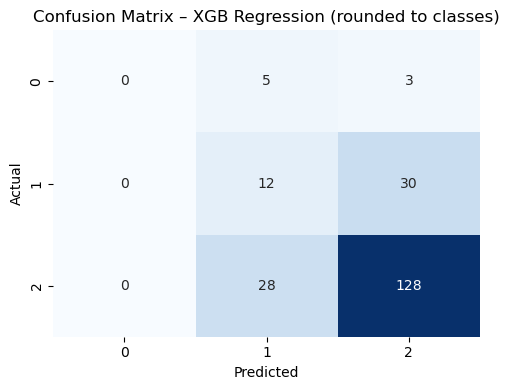

In [283]:
# Confusion matrix for XGBoost reg-as-class classifier
# Round and clip predictions to class labels 0/1/2
y_pred_class = np.clip(np.rint(y_pred_val).astype(int), 0, 2)
cm_xgb = confusion_matrix(y_val, y_pred_class, labels=[0,1,2])

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix – XGB Regression (rounded to classes)')
plt.tight_layout()
plt.show()


In [284]:
# -------------------------
# ROC–AUC per class
# -------------------------
y_true = np.array(y_true_classes)

y0 = (y_true == 0).astype(int)
y1 = (y_true == 1).astype(int)
y2 = (y_true == 2).astype(int)

# AUCs
auc0 = roc_auc_score(y0, y_pred_val)
auc1 = roc_auc_score(y1, y_pred_val)
auc2 = roc_auc_score(y2, y_pred_val)

print("\nROC–AUC Scores:")
print("Class 0 vs Rest:", auc0)
print("Class 1 vs Rest:", auc1)
print("Class 2 vs Rest:", auc2)


ROC–AUC Scores:
Class 0 vs Rest: 0.19444444444444445
Class 1 vs Rest: 0.508493031358885
Class 2 vs Rest: 0.5545512820512821


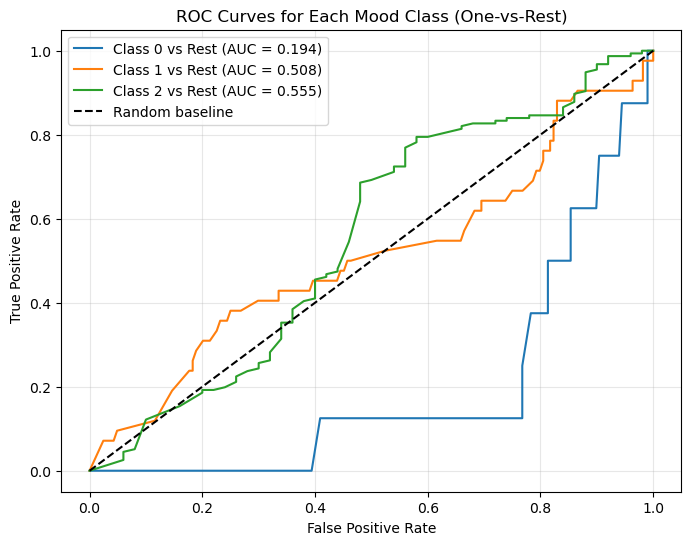

In [285]:
# # ROC curves
fpr0, tpr0, _ = roc_curve(y0, y_pred_val)
fpr1, tpr1, _ = roc_curve(y1, y_pred_val)
fpr2, tpr2, _ = roc_curve(y2, y_pred_val)

plt.figure(figsize=(8,6))

plt.plot(fpr0, tpr0, label=f"Class 0 vs Rest (AUC = {auc0:.3f})")
plt.plot(fpr1, tpr1, label=f"Class 1 vs Rest (AUC = {auc1:.3f})")
plt.plot(fpr2, tpr2, label=f"Class 2 vs Rest (AUC = {auc2:.3f})")

plt.plot([0,1], [0,1], 'k--', label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Mood Class (One-vs-Rest)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Log Reg with manually selected features

In [286]:
X_train.columns

Index(['Caffeine Consumption', 'Vitamins?', 'Creatine?', 'Alcohol?', 'Bread?',
       'Gym Motivation', 'Mood of the Day', 'Hours of Sleep', 'Healthy Eats',
       'Day_sin', 'Day_cos', 'Is Weekend', 'Gym', 'MoodLag2', 'MoodLag3',
       'Vitamins Rolling Sum 7', 'Hours of Sleep Rolling Sum 4',
       'Creatine Rolling Sum 7', 'Gym Rolling Sum 4',
       'Healthy Eats Rolling Sum 4', 'Mood of the Day Rolling Sum 4',
       'Sleep EWM', 'Mood EWM', 'Healthy Eats EWM', 'Gym Motivation EWM',
       'Gym EWM', 'Caffeine Consumption EWM', 'Days Since Gym',
       'Days Since Vitamins'],
      dtype='object')

In [287]:
X_train_lr = X_train[['Mood EWM', 'Alcohol?', 'Caffeine Consumption',
                'Bread?','Day_sin', 'Day_cos', 'Is Weekend', 'Vitamins Rolling Sum 7',
                'Creatine Rolling Sum 7', 'Sleep EWM',
                'Gym Motivation EWM', 'Healthy Eats EWM']]
X_val_lr = X_val[['Mood EWM', 'Alcohol?', 'Caffeine Consumption',
                'Bread?','Day_sin', 'Day_cos', 'Is Weekend', 'Vitamins Rolling Sum 7',
                'Creatine Rolling Sum 7', 'Sleep EWM',
                'Gym Motivation EWM', 'Healthy Eats EWM']]


In [288]:
X_vif = sm.add_constant(X_train_lr)

vif_df = pd.DataFrame()
vif_df['feature'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

In [289]:
vif_df

,feature,VIF
0,const,479.139211
1,Mood EWM,1.393539
2,Alcohol?,1.129094
3,Caffeine Consumption,1.056218
4,Bread?,1.172693
5,Day_sin,2.775000
6,Day_cos,1.178866
7,Is Weekend,2.758058
8,Vitamins Rolling Sum 7,1.929206
9,Creatine Rolling Sum 7,2.029413


In [290]:
mod = OrderedModel(
    y_train,
    X_train_lr,
    distr='logit',
    weights=w_train
)

res = mod.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.651083
         Iterations: 68
         Function evaluations: 72
         Gradient evaluations: 72
                              OrderedModel Results                              
Dep. Variable:     Independent Variable   Log-Likelihood:                -311.87
Model:                     OrderedModel   AIC:                             651.7
Method:              Maximum Likelihood   BIC:                             710.1
Date:                  Sun, 25 Jan 2026                                         
Time:                          13:56:19                                         
No. Observations:                   479                                         
Df Residuals:                       465                                         
Df Model:                            12                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
--------

In [291]:
probs_val = res.model.predict(res.params, exog=X_val_lr)

auc0 = roc_auc_score(y0, probs_val[:, 0])
auc1 = roc_auc_score(y1, probs_val[:, 1])
auc2 = roc_auc_score(y2, probs_val[:, 2])

print("Validation AUC for class 0:", auc0)
print("Validation AUC for class 1:", auc1)
print("Validation AUC for class 2:", auc2)

Validation AUC for class 0: 0.779040404040404
Validation AUC for class 1: 0.5836236933797909
Validation AUC for class 2: 0.6307692307692309


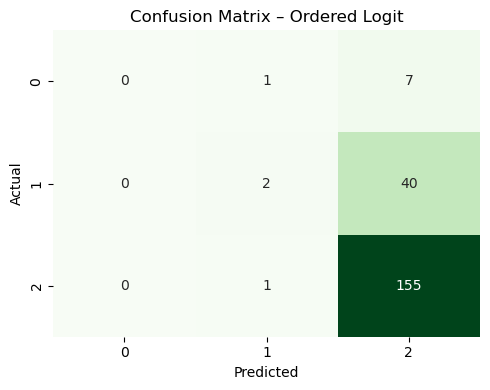

In [292]:
# Confusion matrix for Ordered Logit model
y_pred_ord = probs_val.argmax(axis=1)
cm_ord = confusion_matrix(y_val, y_pred_ord, labels=[0,1,2])

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm_ord, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix – Ordered Logit')
plt.tight_layout()
plt.show()


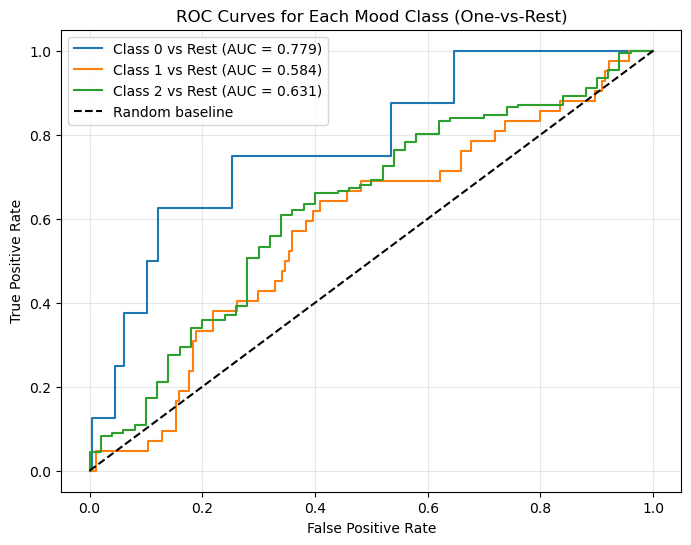

In [293]:
# # ROC curves
fpr0, tpr0, _ = roc_curve(y0, probs_val[:, 0])
fpr1, tpr1, _ = roc_curve(y1, probs_val[:, 1])
fpr2, tpr2, _ = roc_curve(y2, probs_val[:, 2])

plt.figure(figsize=(8,6))

plt.plot(fpr0, tpr0, label=f"Class 0 vs Rest (AUC = {auc0:.3f})")
plt.plot(fpr1, tpr1, label=f"Class 1 vs Rest (AUC = {auc1:.3f})")
plt.plot(fpr2, tpr2, label=f"Class 2 vs Rest (AUC = {auc2:.3f})")

plt.plot([0,1], [0,1], 'k--', label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Mood Class (One-vs-Rest)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Elastic Net

In [294]:
# Elastic net feature selection (multinomial logistic)
l1_ratios = np.linspace(0.0, 1.0, 6)
logit_cv = LogisticRegressionCV(
    Cs=10,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=l1_ratios,
    cv=5,
    multi_class='multinomial',
    scoring='neg_log_loss',
    max_iter=5000,
    n_jobs=-1,
    refit=True
)
logit_cv.fit(X_train, y_train, sample_weight=w_train)

coef_mat = logit_cv.coef_
feature_scores = np.abs(coef_mat).max(axis=0)
selected_features = X_train.columns[feature_scores > 1e-5].tolist()

# Fallback: keep top 10 by magnitude if everything shrinks to zero
if len(selected_features) == 0:
    selected_features = X_train.columns[feature_scores.argsort()[-10:]].tolist()

print('Selected features via elastic net:', selected_features)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Selected features via elastic net: ['Mood of the Day', 'MoodLag2', 'MoodLag3', 'Vitamins Rolling Sum 7', 'Hours of Sleep Rolling Sum 4', 'Creatine Rolling Sum 7', 'Gym Rolling Sum 4', 'Healthy Eats Rolling Sum 4', 'Mood of the Day Rolling Sum 4', 'Days Since Gym', 'Days Since Vitamins']


In [295]:
# Logistic regression using elastic net-selected features
logreg_final = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=2000
)
logreg_final.fit(X_train[selected_features], y_train, sample_weight=w_train)

val_pred = logreg_final.predict(X_val[selected_features])
test_pred = logreg_final.predict(X_test[selected_features])

print('Validation accuracy:', accuracy_score(y_val, val_pred))
print('Test accuracy:', accuracy_score(y_test, test_pred))


Validation accuracy: 0.6650485436893204
Test accuracy: 0.6666666666666666


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [296]:
# Validation AUC per class for elastic-net-selected logistic regression
probs_val_lr = logreg_final.predict_proba(X_val[selected_features])

y0_val = (y_val == 0).astype(int)
y1_val = (y_val == 1).astype(int)
y2_val = (y_val == 2).astype(int)

aut_class0 = roc_auc_score(y0_val, probs_val_lr[:, 0])
aut_class1 = roc_auc_score(y1_val, probs_val_lr[:, 1])
aut_class2 = roc_auc_score(y2_val, probs_val_lr[:, 2])

print("Validation AUC for class 0:", aut_class0)
print("Validation AUC for class 1:", aut_class1)
print("Validation AUC for class 2:", aut_class2)


Validation AUC for class 0: 0.7534722222222222
Validation AUC for class 1: 0.5039924506387921
Validation AUC for class 2: 0.5878205128205128


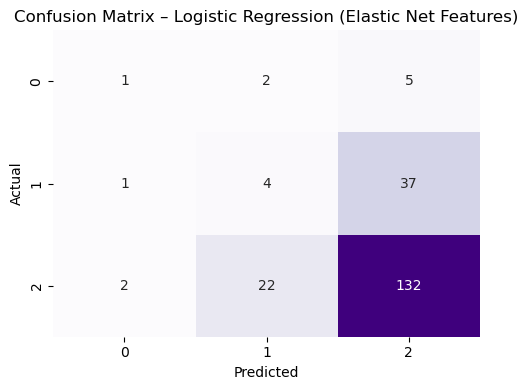

In [297]:
# Confusion matrix (validation) for elastic-net-selected logistic regression
y_pred_val_lr = probs_val_lr.argmax(axis=1)
cm_val_lr = confusion_matrix(y_val, y_pred_val_lr, labels=[0,1,2])

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm_val_lr, annot=True, fmt='d', cmap='Purples', cbar=False, ax=ax,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix – Logistic Regression (Elastic Net Features)')
plt.tight_layout()
plt.show()


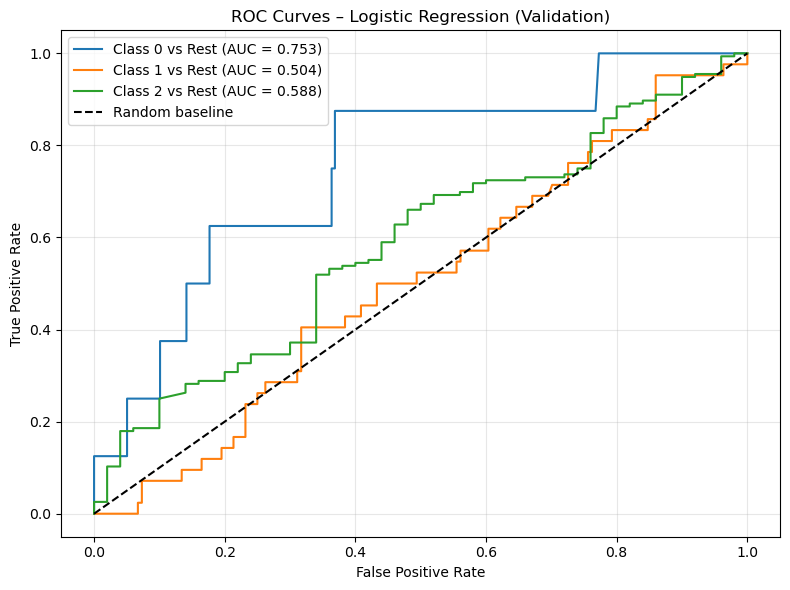

In [298]:
# ROC curves (validation) for elastic-net-selected logistic regression
fpr0, tpr0, _ = roc_curve(y0_val, probs_val_lr[:, 0])
fpr1, tpr1, _ = roc_curve(y1_val, probs_val_lr[:, 1])
fpr2, tpr2, _ = roc_curve(y2_val, probs_val_lr[:, 2])

plt.figure(figsize=(8,6))
plt.plot(fpr0, tpr0, label=f"Class 0 vs Rest (AUC = {aut_class0:.3f})")
plt.plot(fpr1, tpr1, label=f"Class 1 vs Rest (AUC = {aut_class1:.3f})")
plt.plot(fpr2, tpr2, label=f"Class 2 vs Rest (AUC = {aut_class2:.3f})")
plt.plot([0,1], [0,1], 'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Logistic Regression (Validation)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# XGBOOST with manually selected features

In [299]:
# XGBoost classifier using handpicked logistic-regression features
xgb_manual = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.9,
    colsample_bytree=0.9
)

xgb_manual.fit(X_train_lr, y_train, sample_weight=w_train)

probs_val_xgb = xgb_manual.predict_proba(X_val_lr)
y_pred_val_xgb = probs_val_xgb.argmax(axis=1)

print('XGB (manual features) validation accuracy:', accuracy_score(y_val, y_pred_val_xgb))


XGB (manual features) validation accuracy: 0.6747572815533981


In [300]:
# Validation AUC per class for XGB (manual features)
y0_val = (y_val == 0).astype(int)
y1_val = (y_val == 1).astype(int)
y2_val = (y_val == 2).astype(int)

a0 = roc_auc_score(y0_val, probs_val_xgb[:,0])
a1 = roc_auc_score(y1_val, probs_val_xgb[:,1])
a2 = roc_auc_score(y2_val, probs_val_xgb[:,2])

print('Validation AUC class 0:', a0)
print('Validation AUC class 1:', a1)
print('Validation AUC class 2:', a2)


Validation AUC class 0: 0.7544191919191919
Validation AUC class 1: 0.48403019744483156
Validation AUC class 2: 0.537051282051282


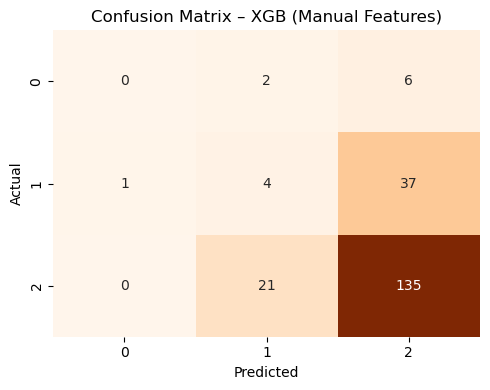

In [301]:
# Confusion matrix (validation) for XGB (manual features)
cm_val_xgb = confusion_matrix(y_val, y_pred_val_xgb, labels=[0,1,2])

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm_val_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=ax,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix – XGB (Manual Features)')
plt.tight_layout()
plt.show()


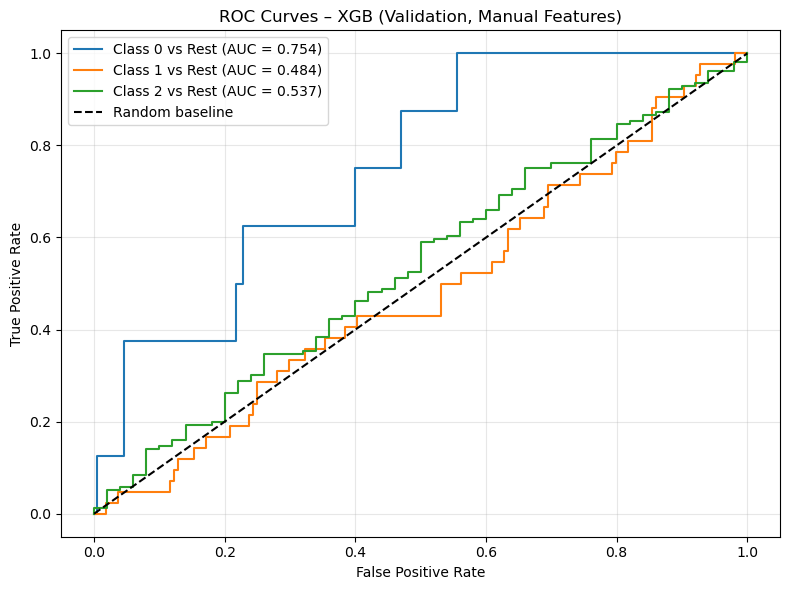

In [302]:
# ROC curves (validation) for XGB (manual features)
fpr0, tpr0, _ = roc_curve(y0_val, probs_val_xgb[:,0])
fpr1, tpr1, _ = roc_curve(y1_val, probs_val_xgb[:,1])
fpr2, tpr2, _ = roc_curve(y2_val, probs_val_xgb[:,2])

plt.figure(figsize=(8,6))
plt.plot(fpr0, tpr0, label=f"Class 0 vs Rest (AUC = {a0:.3f})")
plt.plot(fpr1, tpr1, label=f"Class 1 vs Rest (AUC = {a1:.3f})")
plt.plot(fpr2, tpr2, label=f"Class 2 vs Rest (AUC = {a2:.3f})")
plt.plot([0,1],[0,1],'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – XGB (Validation, Manual Features)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Download model

## Production Model: Multinomial Logistic Regression (Handpicked Features)
- Chosen features: `Mood EWM`, `Alcohol?`, `Caffeine Consumption`, `Bread?`, `Day_sin`, `Day_cos`, `Is Weekend`, `Vitamins Rolling Sum 7`, `Creatine Rolling Sum 7`, `Sleep EWM`, `Gym Motivation EWM`, `Healthy Eats EWM`.
- Trained on the full aligned dataset (train + val) with sample weights emphasizing classes 0/1.
- Artifacts saved: `models/logreg_manual_full.pkl` (fitted model) and `models/logreg_manual_features.json` (feature order).
- Load example:
```python
import joblib, json
model = joblib.load('models/logreg_manual_full.pkl')
with open('models/logreg_manual_features.json') as f:
    features = json.load(f)
X_new = df[features]
probs = model.predict_proba(X_new)
preds = model.predict(X_new)
```


In [304]:
# Train full-data logistic regression (handpicked features) and save artifacts
from pathlib import Path
import joblib, json

feature_list = ['Mood EWM', 'Alcohol?', 'Caffeine Consumption',
                'Bread?','Day_sin', 'Day_cos', 'Is Weekend', 'Vitamins Rolling Sum 7',
                'Creatine Rolling Sum 7', 'Sleep EWM',
                'Gym Motivation EWM', 'Healthy Eats EWM']

logreg_manual_full = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=2000
)

# Fit on all data (X, y) with the original sample_weights
logreg_manual_full.fit(X[feature_list], y, sample_weight=sample_weights)

# Save artifacts
Path('models').mkdir(exist_ok=True)
joblib.dump(logreg_manual_full, 'models/logreg_manual_full.pkl')
with open('models/logreg_manual_features.json', 'w') as f:
    json.dump(feature_list, f)
print('Saved model to models/logreg_manual_full.pkl and features to models/logreg_manual_features.json')


Saved model to models/logreg_manual_full.pkl and features to models/logreg_manual_features.json


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
